In [494]:
import pandas as pd
from itertools import combinations
from collections import Counter
import math

# -------------------------------
# Ideological spectrum (manually defined, -5=far-left to +5=far-right)
# -------------------------------
IDEOLOGY_MAP = {
    "SP": -5,
    "PvdA": -3,
    "GL": -3,
    "PvdD": -2,
    "D66": -1,
    "Volt": -1,
    "CDA": 1,
    "CU": 1,
    "SGP": 2,
    "VVD": 3,
    "JA21": 4,
    "PVV": 5,
    "BBB": 2,
    "Forum voor Democratie": 5,
    "DENK": -4,
    "50PLUS": 0,
    "BIJ1": -5,
    "LP": 3,
    "NSC": 1
}

In [495]:
# -------------------------------
# Load and normalize data
# -------------------------------
# def load_data():
#     kabinetten = pd.read_csv('data/cabinets/kabinetten_schoongemaakt.csv')
#     zetels_100 = pd.read_csv('data/zetelverdeling/zetel-data/tk_zetels100_1918-1956.csv')
#     zetels_150 = pd.read_csv('data/zetelverdeling/zetel-data/tk_zetels150_1956-2023.csv')
#     zetels = pd.concat([zetels_100, zetels_150], ignore_index=True)

#     kabinetten['Partijen'] = kabinetten['Partijen'].dropna().str.split(', ')
#     return kabinetten, zetels
def load_data():
    kabinetten = pd.read_csv('data/cabinets/kabinetten_schoongemaakt-no2021.csv')
    zetels_100 = pd.read_csv('data/zetelverdeling/zetel-data/tk_zetels100_1918-1956.csv')
    zetels_150 = pd.read_csv('data/zetelverdeling/zetel-data/tk_zetels150_1956-2023-no2021.csv')
    zetels = pd.concat([zetels_100, zetels_150], ignore_index=True)

    kabinetten['Partijen'] = kabinetten['Partijen'].dropna().str.split(', ')
    return kabinetten, zetels

In [496]:
# -------------------------------
# Build historical coalition frequency model
# -------------------------------
def build_coalition_frequency(kabinetten):
    coalition_counter = Counter()
    for partijen in kabinetten['Partijen'].dropna():
        for r in range(2, len(partijen) + 1):
            for combo in combinations(sorted(partijen), r):
                coalition_counter[combo] += 1
    return coalition_counter

In [497]:
# -------------------------------
# Ideological compatibility score (lower is better)
# -------------------------------
def ideological_distance(parties):
    ideologies = [IDEOLOGY_MAP.get(p, 0) for p in parties]
    if len(ideologies) <= 1:
        return 0
    variance = sum((i - sum(ideologies)/len(ideologies))**2 for i in ideologies) / len(ideologies)
    return math.sqrt(variance)

In [498]:
# -------------------------------
# Reduce impact of smaller parties
# -------------------------------
def scaled_seat_weight(seat_count):
    """Scale the impact of a party's seat count using a logarithmic function."""
    # We use log scale to reduce the influence of smaller parties.
    return math.log(seat_count + 1)  # +1 to avoid log(0)

In [499]:
# -------------------------------
# Define unrealistic combinations (only add the ones that are definitely unrealistic)
# -------------------------------
def is_unrealistic_combo(parties):
    # Add more logic if needed
    extremes = [
        ('FvD', 'Volt'),
        ('PVV', 'BIJ1'),
        ('SGP', 'BIJ1'),
        ('FvD', 'D66'),
        ('PVV', 'GL/PvdA'),
        ('PVV', 'DENK'),
        ('PVV', 'Volt'),
        ('SGP', 'Volt'),
        ('GL/PvdA', 'BBB'),
        ('PVV', 'D66'),
    ]
    party_set = set(parties)
    for a, b in extremes:
        if a in party_set and b in party_set:
            return True
    return False

In [500]:
# -------------------------------
# Define new parties
# -------------------------------
PARTY_LINEAGE = {
    "GL/PvdA": ["GL", "PvdA"],  # Merged parties
    "NSC": ["CDA"],             # NSC is a breakaway from CDA
    "JA21": ["FvD"],            # JA21 split from FvD
    # Add other mappings if necessary
}

def expand_party(party):
    """Return historical equivalents for a party (e.g., GL/PvdA -> [GL, PvdA])"""
    return PARTY_LINEAGE.get(party, [party])

def get_expanded_coalition(combo):
    """Expand a coalition to include historical equivalents"""
    expanded = set()
    for party in combo:
        expanded.update(expand_party(party))
    return expanded

def calculate_historical_score(combo, coalition_counter, seat_distribution):
    """Compute adjusted historical overlap score using lineage info and seat scaling"""
    expanded_combo = get_expanded_coalition(combo)

    score = 0
    total_weight = 0  # To keep track of the total weight for normalization
    
    for historical_coalition in coalition_counter:
        overlap = expanded_combo & set(historical_coalition)
        
        if len(overlap) >= 2:  # If there's enough overlap
            # Calculate overlap score: how much overlap, divided by the total length of the coalition
            overlap_score = len(overlap) / len(historical_coalition)
            
            # Check if it's a lineage-based match (partial weight) or direct match (full weight)
            if any(party in PARTY_LINEAGE for party in combo):
                # If it's from a different lineage, give partial weight
                overlap_score *= 0.5  # Apply 50% weight for lineage-based matches
            
            # Sum the weighted overlap score, scaled by seat count
            for party in combo:
                party_weight = scaled_seat_weight(seat_distribution[party])
                total_weight += party_weight
                score += coalition_counter[historical_coalition] * overlap_score * party_weight
    
    # Normalize the score by the total weight of the parties in the combo
    if total_weight > 0:
        score /= total_weight
    return score

In [501]:
# -------------------------------
# Define main prediction function
# -------------------------------
def predict_coalitions(seat_distribution, coalition_counter, threshold=76, top_k=5):
    parties = list(seat_distribution.keys())
    valid_coalitions = []

    for r in range(2, len(parties) + 1):
        for combo in combinations(parties, r):

            # -------------------------------
            # Check if the coalition includes the largest party (comment if opposition coalition)
            largest_party = max(seat_distribution.items(), key=lambda x: x[1])[0]
            if largest_party not in combo:
                continue  # Skip coalitions that don't include the largest party 
            # -------------------------------

            seats = sum(seat_distribution[p] for p in combo)
            if seats >= threshold:

                if is_unrealistic_combo(combo):
                    continue

                # Calculate historical score with lineage adjustments and seat scaling
                historical_score = calculate_historical_score(combo, coalition_counter, seat_distribution)
                
                # Calculate ideology score
                ideology_score = ideological_distance(combo)

                # Apply penalties for party count and seat surplus
                party_penalty = max(0, len(combo) - 4) * 2
                surplus_penalty = max(0, seats - 90) * 0.5

                # Final score computation
                final_score = (historical_score * 2) - (ideology_score * 2) - party_penalty - surplus_penalty


                valid_coalitions.append({
                    "coalition": combo,
                    "seats": seats,
                    "historical_score": round(historical_score, 2),
                    "ideology_score": round(ideology_score, 2),
                    "party_penalty": round(party_penalty, 2),
                    "surplus_penalty": round(surplus_penalty, 2),
                    "final_score": round(final_score, 2)
                })

    valid_coalitions.sort(key=lambda x: (-x["final_score"], x["seats"]))  # Favor lower seat counts
    return valid_coalitions[:top_k]

In [506]:
# -------------------------------
# Example usage
# -------------------------------
if __name__ == "__main__":
    kabinetten, zetels = load_data()
    coalition_counter = build_coalition_frequency(kabinetten)

    # User Input
    seat_distribution = {
    'PVV':17,
    'VVD':34,
    'D66':24,
    'BBB':1,
    'CDA':15,
    'SP':9,
    'FvD':8,
    'PvdD':6,
    'SGP':3,
    'ChristenUnie':5,
    'DENK':3,
    'Volt':3,
    'JA21':3,
    'PvdA':9,
    'GroenLinks':8,
    '50Plus':1,
    'BIJ1':1,
}

    predictions = predict_coalitions(seat_distribution, coalition_counter, threshold=76, top_k=7)
    
    for p in predictions:
        print(f"Coalition: {p['coalition']}")
        print(f"  Seats: {p['seats']}")
        print(f"  History Score: {p['historical_score']}")
        print(f"  Ideology Score: {p['ideology_score']}")
        print(f"  Party Penalty: {p['party_penalty']}")
        print(f"  Surplus Penalty: {p['surplus_penalty']}")
        print(f"  Final Score: {p['final_score']}")
        print("")

Coalition: ('VVD', 'D66', 'CDA', 'SGP')
  Seats: 76
  History Score: 1.97
  Ideology Score: 1.48
  Party Penalty: 0
  Surplus Penalty: 0.0
  Final Score: 0.99

Coalition: ('VVD', 'D66', 'CDA', 'GroenLinks')
  Seats: 81
  History Score: 1.97
  Ideology Score: 1.48
  Party Penalty: 0
  Surplus Penalty: 0.0
  Final Score: 0.99

Coalition: ('VVD', 'D66', 'CDA', 'ChristenUnie')
  Seats: 78
  History Score: 1.83
  Ideology Score: 1.48
  Party Penalty: 0
  Surplus Penalty: 0.0
  Final Score: 0.71

Coalition: ('VVD', 'D66', 'CDA', 'Volt')
  Seats: 76
  History Score: 1.97
  Ideology Score: 1.66
  Party Penalty: 0
  Surplus Penalty: 0.0
  Final Score: 0.63

Coalition: ('VVD', 'D66', 'CDA', 'PvdD')
  Seats: 79
  History Score: 1.98
  Ideology Score: 1.92
  Party Penalty: 0
  Surplus Penalty: 0.0
  Final Score: 0.11

Coalition: ('VVD', 'D66', 'CDA', 'PvdA')
  Seats: 82
  History Score: 1.97
  Ideology Score: 2.24
  Party Penalty: 0
  Surplus Penalty: 0.0
  Final Score: -0.54

Coalition: ('VVD', '

In [ ]:
parties_2023 = {
        'VVD': 24,
        'PvdA': 0,
        'GL': 25,
        'D66': 9,
        'CDA': 5,
        'CU': 3,
        'PVV': 37,
        'BBB': 7,
        'SP': 5,
        'PvdD': 3,
        'NSC': 20,
        'DENK': 3,
        'FvD': 3,
        'SGP': 3,
        'Volt': 2,
        'JA21': 1
}

parties_2021 = {
    'PVV':17,
    'VVD':34,
    'D66':24,
    'BBB':1,
    'CDA':15,
    'SP':9,
    'FvD':8,
    'PvdD':6,
    'SGP':3,
    'ChristenUnie':5,
    'DENK':3,
    'Volt':3,
    'JA21':3,
    'PvdA':9,
    'GroenLinks':8,
    '50Plus':1,
    'BIJ1':1,
}

/tmp/ipykernel_427928/254859779.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_scores, y=coalitions, palette='viridis')


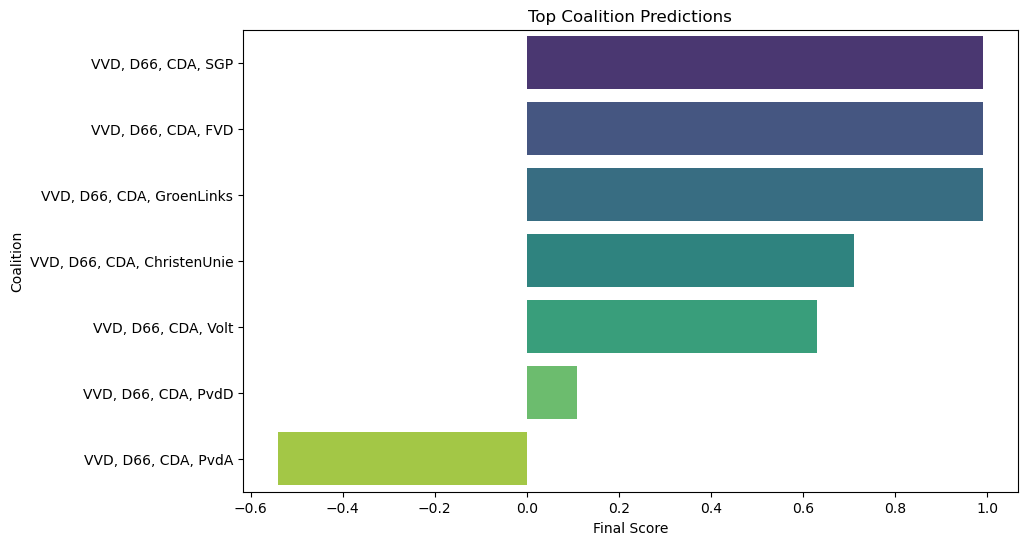

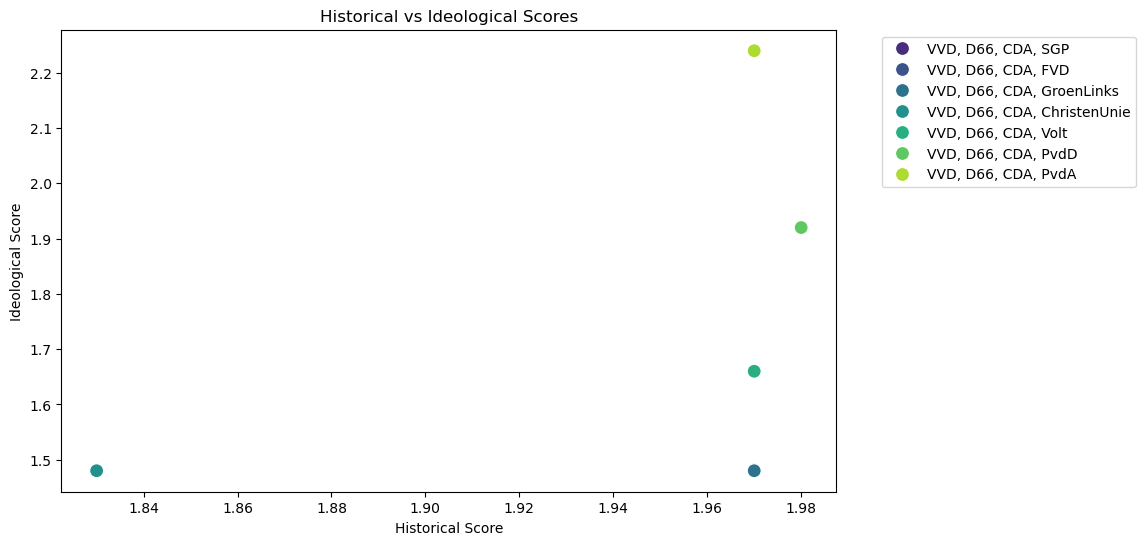

In [504]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_coalition_scores(predictions):
    coalitions = [', '.join(p['coalition']) for p in predictions]
    final_scores = [p['final_score'] for p in predictions]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=final_scores, y=coalitions, palette='viridis')
    plt.xlabel('Final Score')
    plt.ylabel('Coalition')
    plt.title('Top Coalition Predictions')
    plt.show()


def plot_historical_vs_ideological(predictions):
    historical_scores = [p['historical_score'] for p in predictions]
    ideological_scores = [p['ideology_score'] for p in predictions]
    coalitions = [', '.join(p['coalition']) for p in predictions]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=historical_scores, y=ideological_scores, hue=coalitions, palette='viridis', s=100)
    plt.xlabel('Historical Score')
    plt.ylabel('Ideological Score')
    plt.title('Historical vs Ideological Scores')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


plot_coalition_scores(predictions)
plot_historical_vs_ideological(predictions)